In [1]:
%run my_functions.ipynb
import numpy as np
import math
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister,Aer, transpile, execute
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import MCMT

In [2]:
def hybrid_3mct(circuit,clause,clause_number,aux,aux1,f_in,f_out):
    
    control_qbits = [abs(val) for i,val in enumerate(clause) if val!=0]
    control_qbits.append(4)
    circuit.ccx(f_in[control_qbits[0]-1],f_in[control_qbits[1]-1],aux1[0])
    circuit.ccx(f_in[control_qbits[2]-1],f_in[control_qbits[3]-1],aux1[1])
    circuit.ccx(aux1[0],aux1[1],aux1[2])
    circuit.x(aux1[2])
    circuit.ccx(f_in[-1],aux1[2],aux[clause_number])
    circuit.ccx(aux1[0],aux1[1],aux1[2])
    circuit.ccx(f_in[control_qbits[0]-1],f_in[control_qbits[1]-1],aux1[0])
    circuit.ccx(f_in[control_qbits[2]-1],f_in[control_qbits[3]-1],aux1[1])
    # circuit.ccx(f_in[control_qbits[0]-1],f_in[control_qbits[1]-1],aux1[0])
    # circuit.ccx(f_in[control_qbits[2]-1],aux1[0],aux[clause_number])
    # circuit.ccx(f_in[control_qbits[0]-1],f_in[control_qbits[1]-1],aux1[0])
    
    return circuit


def hybrid_oracle(circuit,f_in,f_out,aux,aux1,n,sat_formula):
    
    for j in range(len(sat_formula)):
        clause = sat_formula[j]    
        for i in range(len(clause)):
            #Encoding positive variables
            if clause[i]>0:
                circuit.x(f_in[clause[i]-1])
        hybrid_3mct(circuit,clause,j,aux,aux1,f_in,f_out)
        
        for i in range(len(clause)):
            #Encoding positive variables
            if clause[i]>0:
                circuit.x(f_in[clause[i]-1])
        circuit.barrier()
        
    return circuit  


def diffusion_circ3(circuit,f_in,aux1):
    circuit.h(f_in[:])
    circuit.x(f_in[:])
    circuit.h(f_in[-1])
    if len(f_in[:])==3:
        circuit.ccx(f_in[0],f_in[1],f_in[-1])
    elif len(f_in[:])==4:
        circuit.ccx(f_in[0],f_in[1],aux1[0])
        circuit.ccx(aux1[0],f_in[2],f_in[-1])
        circuit.ccx(f_in[0],f_in[1],aux1[0])
    elif len(f_in[:])==5:
        circuit.ccx(f_in[0],f_in[1],aux1[0])
        circuit.ccx(f_in[2],f_in[3],aux1[1])
        circuit.ccx(aux1[0],aux1[1],f_in[-1])
        circuit.ccx(f_in[0],f_in[1],aux1[0])
        circuit.ccx(f_in[2],f_in[3],aux1[1])
    circuit.h(f_in[-1])
    circuit.x(f_in[:])
    circuit.h(f_in[:])
    circuit.barrier()
    
    return circuit

In [3]:
def hybrid_sat3(sat_formula):
    n = max(max(sat_clause) for sat_clause in sat_formula) + 1
    f_in = QuantumRegister(n)
    f_out = QuantumRegister(1)
    aux = QuantumRegister(len(sat_formula))
    aux1 = QuantumRegister(3)
    cr = ClassicalRegister(n)
    circuit = QuantumCircuit(f_in,f_out,aux,aux1,cr)
    print(n,len(sat_formula))
    #Superposition of input states
    for i in range(n):
        circuit.h(f_in[i])
    circuit.x(f_out[0])
    circuit.h(f_out[0])
    circuit.barrier()
    circuit.barrier()
    
    #oracle
    if len(sat_formula)==3:
        for _ in range(math.ceil(np.pi*math.sqrt(2**n/4)/4 - 0.5)-1):
            hybrid_oracle(circuit,f_in,f_out,aux,aux1,n,sat_formula)
            circuit.ccx(aux[0],aux[1],aux1[0])
            circuit.ccx(aux[2],aux1[0],f_out[0])
            circuit.ccx(aux[0],aux[1],aux1[0])
            
            circuit.barrier()
            diffusion_circ3(circuit,f_in,aux1)
        circuit.measure(f_in[:],cr[:])
            
        return circuit
    else:
        cr=ClassicalRegister(n)
        sat_circuit = QuantumCircuit(f_in,f_out,aux,aux1,cr)
        hybrid_oracle(circuit,f_in,f_out,aux,aux1,n,sat_formula)
        cnz_circuit = MCMT('z',len(sat_formula),1)
        sat_circuit.compose(circuit,list(range(0,n+1+len(sat_formula)+1+2)),list(range(0,n)),inplace=True)
        #print(cnz_circuit.num_qubits)
        #print(n+1+len(sat_formula)+1+cnz_circuit.num_qubits)
        sat_circuit.compose(cnz_circuit,list(range(n-1+cnz_circuit.num_qubits,n-1,-1)),inplace=True)
        #sat_circuit.MCMT('z',len(sat_formula)-1,1)
        sat_circuit.barrier()
        diffusion_circ3(sat_circuit,f_in,aux2)
        
        for _ in range(math.ceil(np.pi*math.sqrt(2**n/4)/4 - 0.5)-1):
            sat_circuit = hybrid_oracle(sat_circuit,f_in,f_out,aux,aux1,n,sat_formula)
            cnz_circuit = MCMT('z',len(sat_formula)-1,1)
            sat_circuit.compose(cnz_circuit,list(range(n,n+cnz_circuit.num_qubits)),inplace=True)
            #sat_circuit.MCMT('z',len(sat_formula)-1,1)
            sat_circuit.barrier()
            diffusion_circ3(sat_circuit,f_in,aux2)
        sat_circuit.measure(f_in[:],cr[:])

    
        return sat_circuit

In [4]:
#Hybrid prblm 5. It has 4 True solutions and 4 False solutions
sat_formula = [[1,2,3],[-1,2,3],[1,-2,3],[1,2,-3]]

4 3


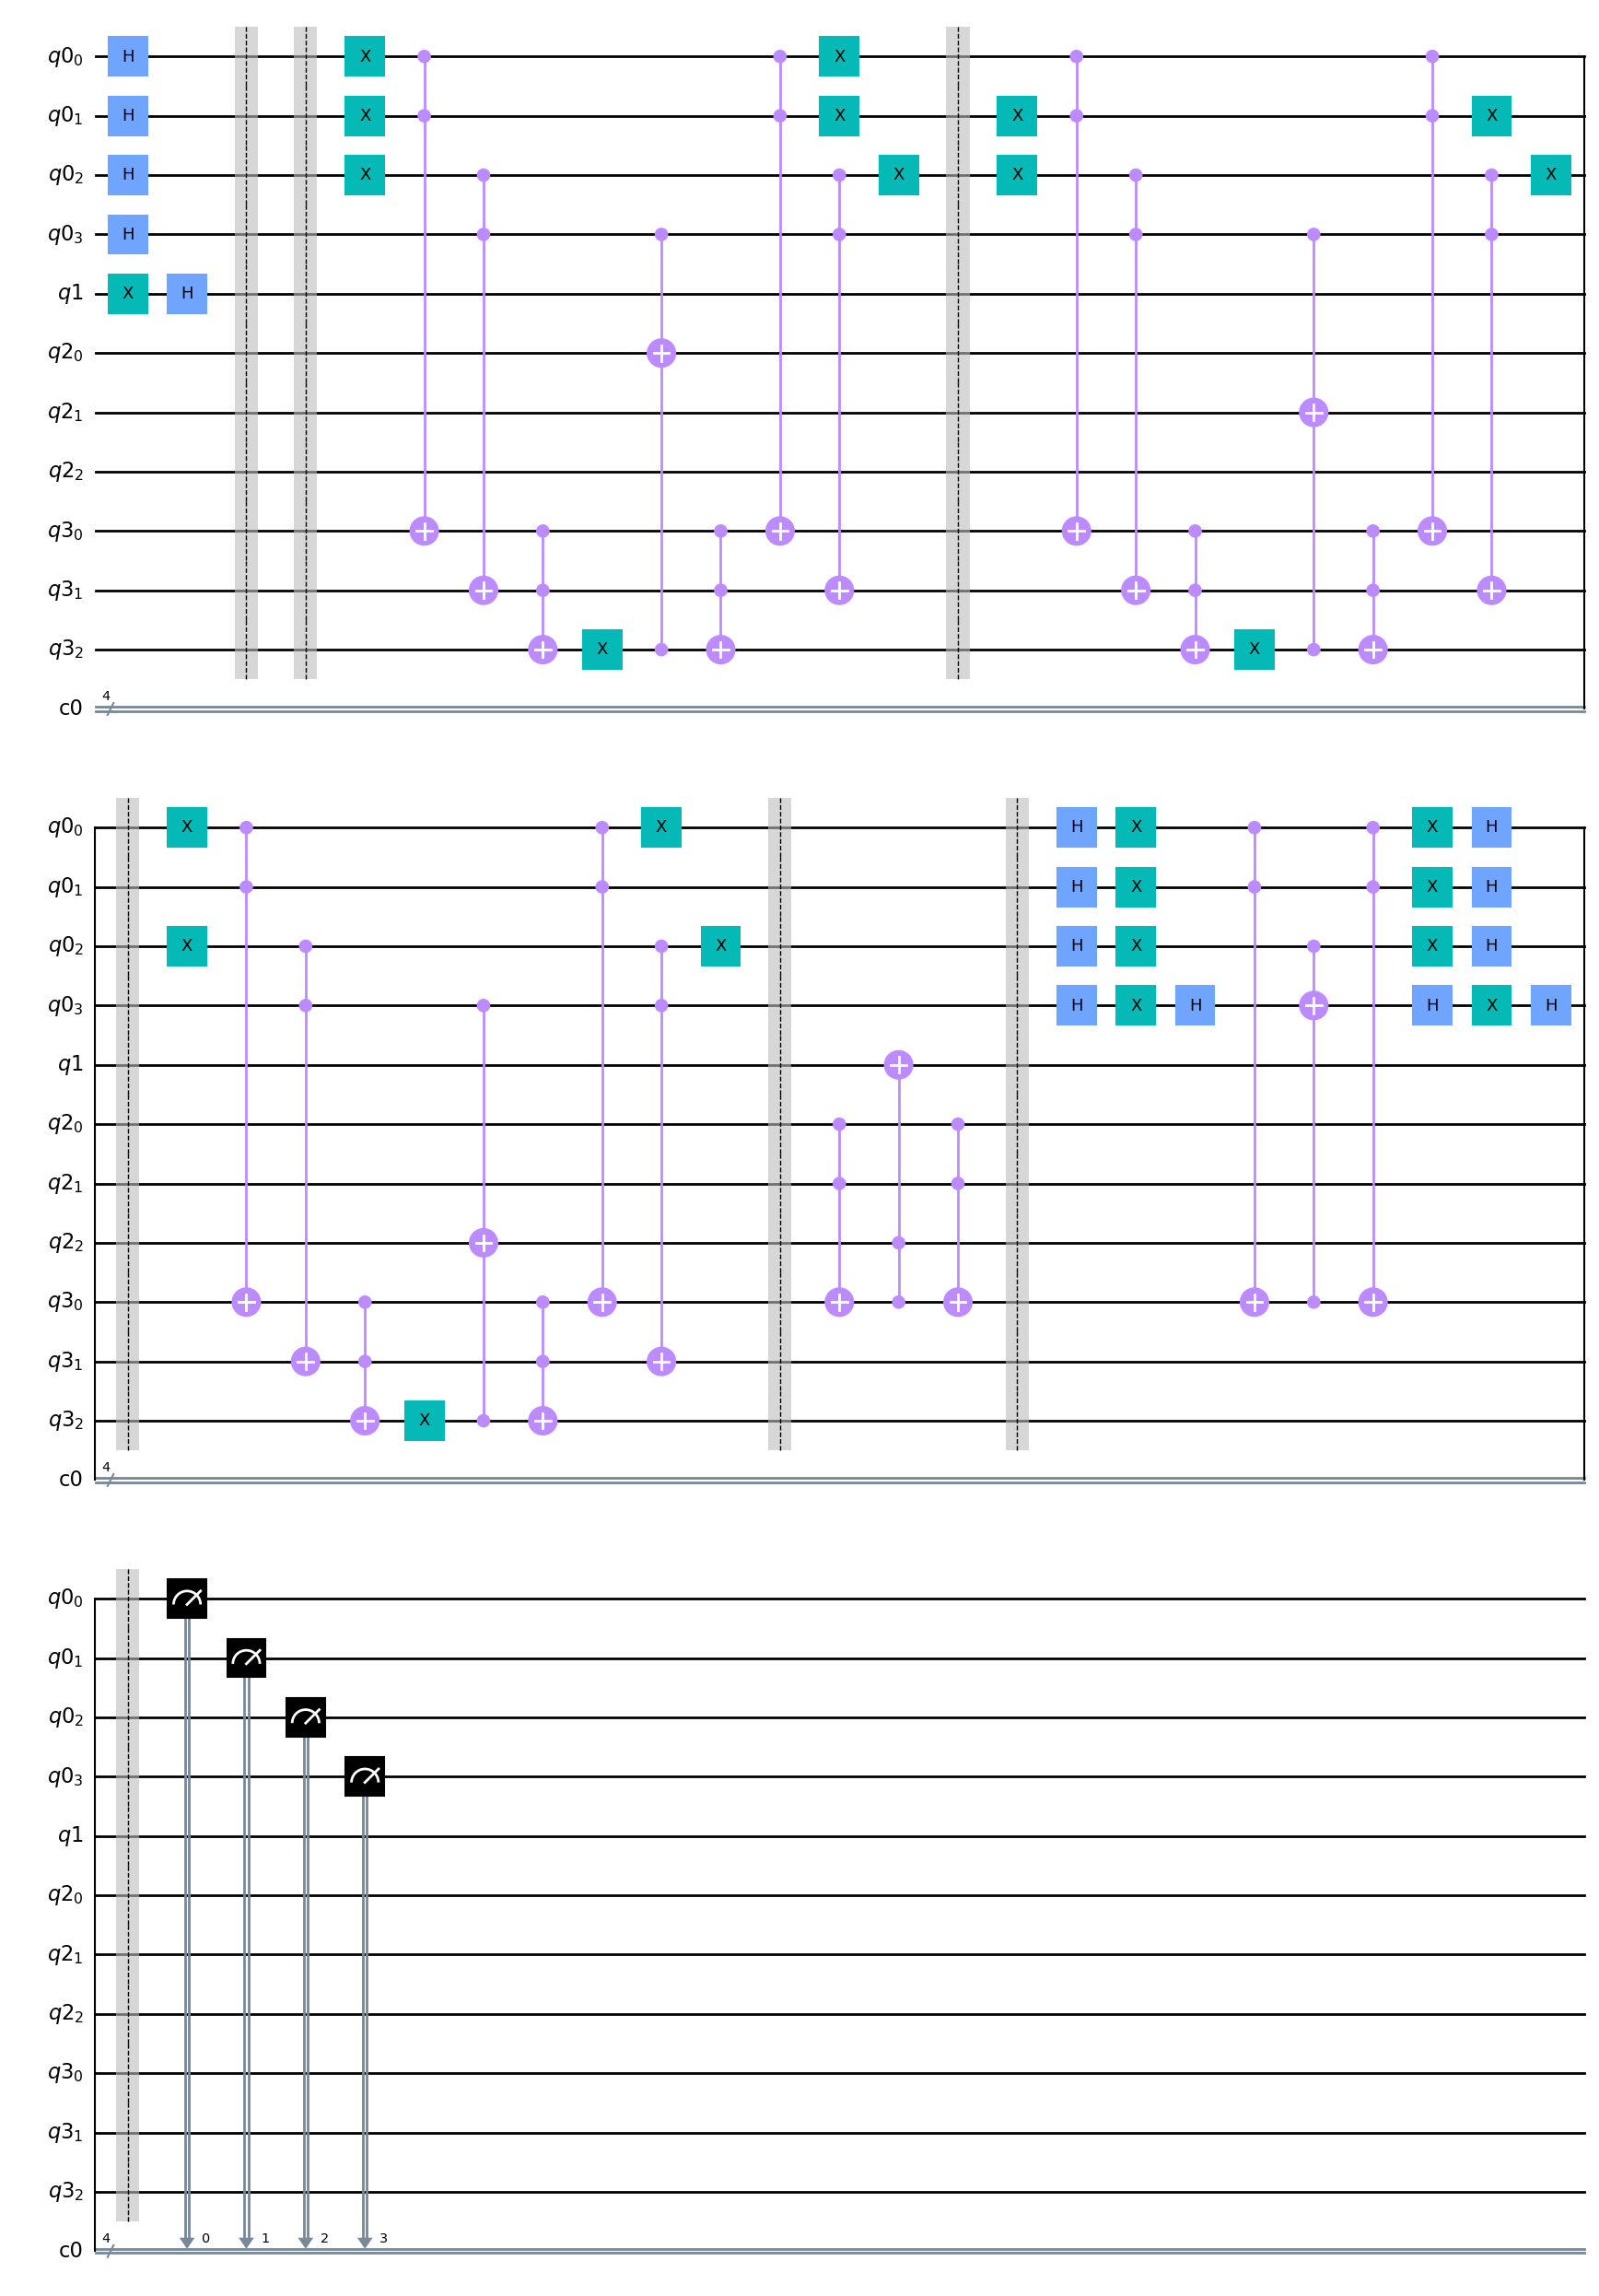

In [5]:
quant_part = []
for i in range(len(sat_formula)-1):
    quant_part += [sat_formula[i]]
qc = hybrid_sat3(quant_part)
qc.draw('mpl')

In [6]:
counts = execute(qc,Aer.get_backend('qasm_simulator'),shots=10000).result().get_counts()
counts = {k: v for k, v in sorted(counts.items(), key=lambda item: item[1], reverse=True)}
soln = []
all_soln = []
for key,value in counts.items():
    all_soln.append(key)
    if value>sum(counts.values())/len(counts):
        soln.append(key)

all_soln = [element[::-1] for element in all_soln]
quant_soln = [element[::-1] for element in soln]
print("Measurement results:",counts)
print("Max values above average from the dictionary:", quant_soln)

Measurement results: {'1001': 1415, '1000': 1376, '1010': 1349, '1011': 787, '1111': 738, '1101': 728, '1110': 712, '1100': 692, '0000': 299, '0111': 291, '0101': 290, '0100': 282, '0011': 270, '0001': 267, '0010': 261, '0110': 243}
Max values above average from the dictionary: ['1001', '0001', '0101', '1101', '1111', '1011', '0111', '0011']


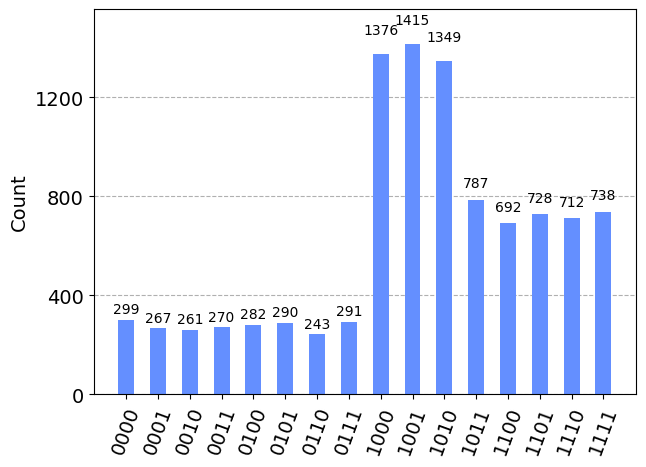

In [7]:
plot_histogram(counts)

In [8]:
brute_quant_soln = classical_sat_checker(quant_part,all_soln)
brute_full_soln = classical_sat_checker(sat_formula,all_soln)

In [9]:
brute_quant_soln

['1101',
 '1111',
 '1011',
 '0111',
 '0011',
 '1110',
 '1010',
 '0010',
 '1100',
 '0110']